In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import KernelPCA, PCA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_train = pd.read_csv('data/training_data/preprocessed_data.csv')

In [5]:
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()
X_train = trans.fit_transform(X_train)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

Covariance Matrix (full - Component):
[[ 1.38139230e+01  3.65767908e+00  4.14372810e-01 ... -2.31433099e-02
  -7.14404004e-03 -4.55221641e-03]
 [ 3.65767908e+00  2.98654995e+01 -5.37993116e+00 ... -5.03098575e-03
  -1.69979312e-03 -1.98017150e-03]
 [ 4.14372810e-01 -5.37993116e+00  1.58177362e+01 ...  1.79357270e-02
   1.02616752e-02  1.55860283e-02]
 ...
 [-2.31433099e-02 -5.03098575e-03  1.79357270e-02 ...  7.78256666e-02
   2.55608756e-03 -1.67234986e-03]
 [-7.14404004e-03 -1.69979312e-03  1.02616752e-02 ...  2.55608756e-03
   7.15822454e-02  9.17409604e-04]
 [-4.55221641e-03 -1.98017150e-03  1.55860283e-02 ... -1.67234986e-03
   9.17409604e-04  7.67852598e-02]]
Covariance Matrix (tied - Component):
[ 1.14842072e+01  2.22996222e+00  1.39728339e+00 -2.59113826e+00
 -1.52401113e+00  1.90722570e+00  1.08128623e-01 -6.29244773e-01
  5.82461895e-01  6.82393395e-01  2.29638903e-01 -3.23281556e-01
 -3.29295821e-01  3.21782687e-01  3.62484577e-01 -5.95394392e-01
 -8.39740098e-04 -6.34032892

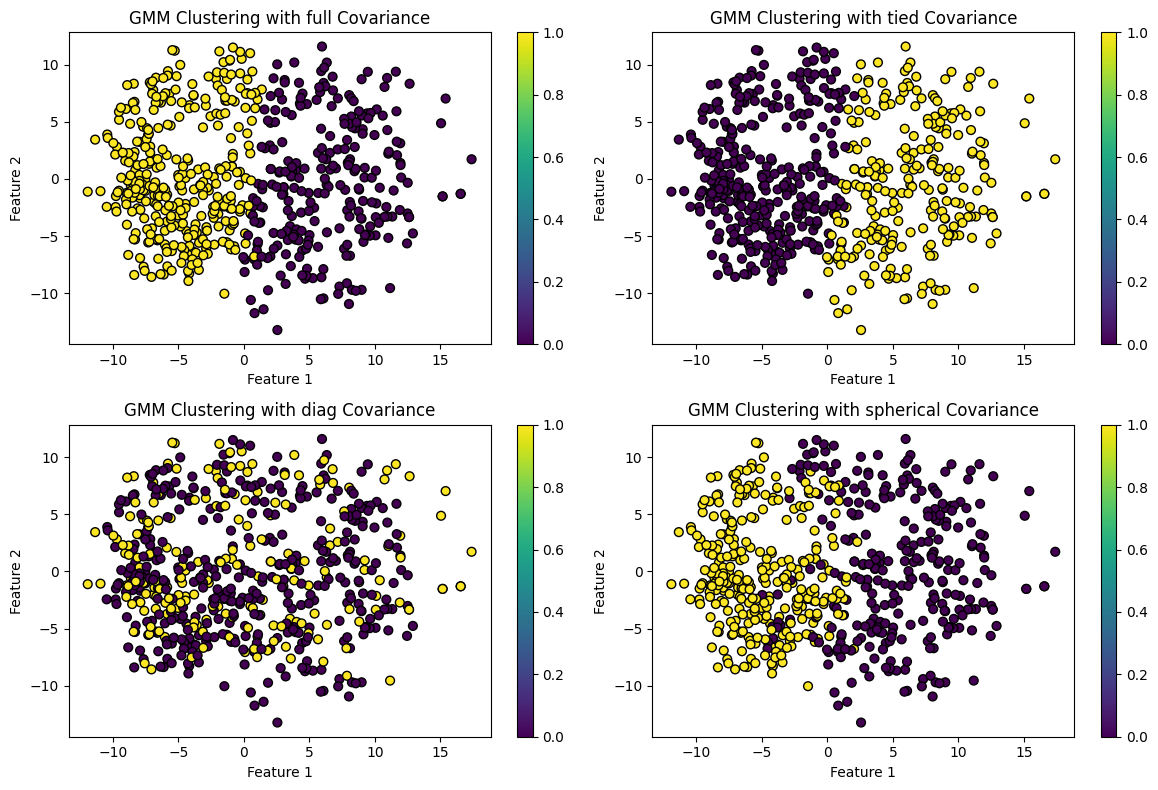

In [12]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

from sklearn.mixture import GaussianMixture
# Initialize GMM models for each covariance type
gmm_models = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

# Fit GMM models for each covariance type
for cov_type, gmm_model in gmm_models.items():
    gmm_model.fit(X_train_pca)

covariances = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models.items()}

# Predict the cluster assignments for all data points
predictions = {cov_type: gmm_model.predict(X_train_pca)
               for cov_type, gmm_model in gmm_models.items()}

# Plot the clusters for each covariance type
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predictions[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()

    # Print the covariance matrix for the first component (adjust as needed)
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances[cov_type][0]}')
plt.tight_layout()
plt.show()

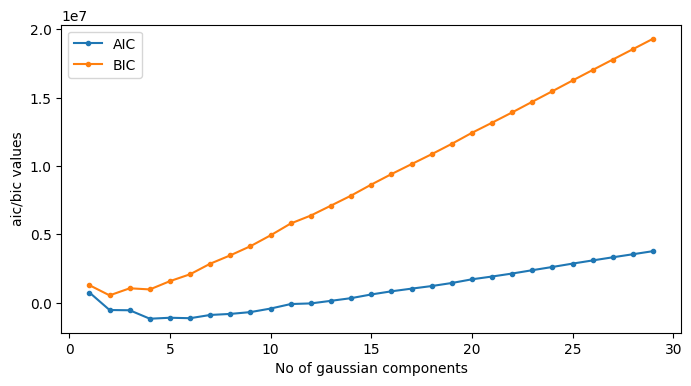

In [14]:
#. Calculate AIC and BIC.
max_cluster = 30

cluster_range = range(1,max_cluster)

def compute_aic_bic(X):
    aic_values = []
    bic_values = []
    for i in cluster_range:
        gmm = GaussianMixture(n_components=i)
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))
    return aic_values, bic_values

aic, bic = compute_aic_bic(X_train_pca)

plt.figure(figsize=(8,4))
plt.plot(cluster_range, aic, marker = '.', label ='AIC')
plt.plot(cluster_range, bic, marker = '.', label ='BIC')
plt.xlabel("No of gaussian components")
plt.ylabel("aic/bic values")
plt.legend()
plt.show()

In [15]:
k = np.argmin(aic)+1
print(f'The optimal number of clusters: {k}')

The optimal number of clusters: 4


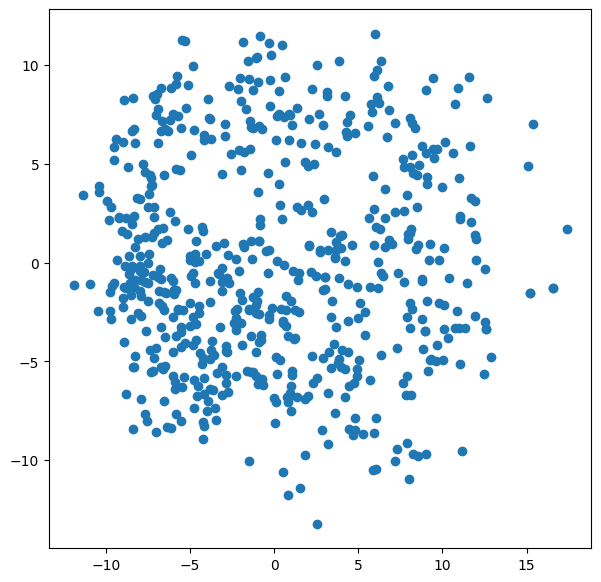

In [16]:
#Plot PCA
plt.figure(figsize=(7,7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.show()

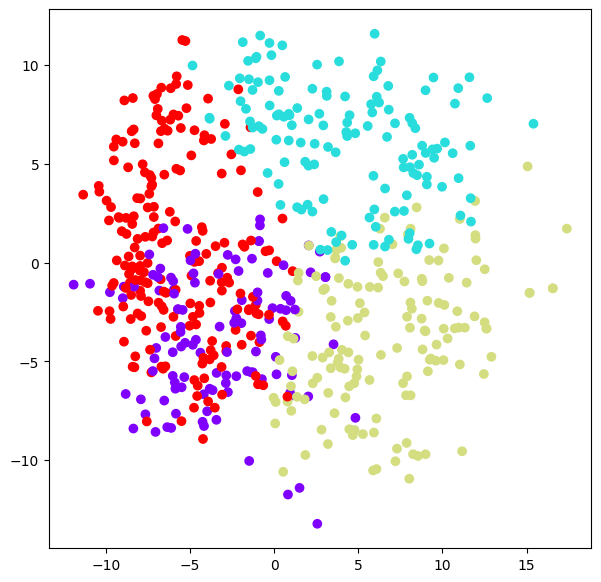

In [17]:
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(X_train_pca)

labels_hard = gmm.predict(X_train_pca)
plt.figure(figsize=(7,7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_hard, cmap='rainbow')
plt.show()